Copyright Optimizing Mind 2023
Optimizing Mind Jupyter notebook for benchmarking transfer learning.
This code compares transfer learning for cats and dogs and is based on the tesor flow tutorial and code.
The code: 
1) initiates the Optimizing Mind API 
2) downloads cats dogs data 
3) runs the tensor flow example learning code
4) runs OM API learning on the exact same data samples as in (3)
5) plots verification and learning curves

Optimizing Mind User Guide for API https://docs.google.com/document/d/1gW8HNtol__A8LChqSs5Q_3wJsFv6A10QCgW0FUH5ZxE
Steps to run Optimizing Mind API
1) Register and obtain API token https://om-learn-api.azurewebsites.net/
2) copy your token and place in \<token\>

Changes from original TF tutorial code:
1) top layer changed from binary to multiclass to allow for multiple labels (no penalty in performance)
2) batch size is changed from the original 32 to 1 in order to be able to better observe OM learning curve (no penalty in performance)
3) TF training loop code changed to a manual one (for loop instead of fit)
4) options added for different datasets
5) options added for different bases
original code: https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb

Note code is slow because lots of validation is run on both models, but it produces detailed learning curves

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import time
import json
import requests

In [2]:
base_inference_shortcut=True
# BATCH_SIZE=1 is best to see OM progress because it learns by 20 samples
BATCH_SIZE =1 #32 was original, TF performance is same

In [3]:
# Code to call API
# user must place valid license token in header authorization
def Send_to_API(top_layer_inputs, labels,num_outputs,model_name="test_model023"):

    top_layer_inputsL = top_layer_inputs.tolist() # inputs
    labelsL = labels.tolist() #labels
    num_outputsL = str(num_outputs) 

    payload = {"model_name":  model_name,'inputs': top_layer_inputsL, 'labels': labelsL,'num_outputs':num_outputsL}
    headers = { 'content-type': 'application/json', 'accept': 'application/json','Authorization':'Bearer <token> }  # <token>

    r = requests.post(url = 'https://om-learn-api.azurewebsites.net/api/train/', data = json.dumps(payload), headers=headers)
    result = json.loads(r.text)
    return(result)

In [4]:
def Get_from_API(data):
    weights = np.array(data["result"]) 
    return(weights)

In [5]:
from datetime import datetime
now=datetime.now()
date_time=now.strftime("%m-%d-%Y")

In [6]:
date_time

'11-20-2023'

In [7]:
print(tf.__version__)

2.12.0


In [8]:
IMG_SIZE = (160, 160)

In [9]:
# sets up the directories automatically  
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [10]:
# Datasets to benchmark

dataset_name='cats_and_dogs_filtered'  #originalTF notebook dataset
#dataset_name='Animals_filtered'  # 50 animal dataset
#dataset_name='fowl_data' # from https://learn.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch

PATH2 = os.path.join(os.path.dirname(path_to_zip),dataset_name )    
print(PATH2)

C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered


In [11]:
train_dir = os.path.join(PATH2, 'train')
validation_dir = os.path.join(PATH2, 'validation')

print(PATH2,'\n',train_dir,'\n',validation_dir)

C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered 
 C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered\train 
 C:\Users\Tsvi\.keras\datasets\cats_and_dogs_filtered\validation


In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                         shuffle=True,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                              shuffle=True,
                                                                              batch_size=BATCH_SIZE,
                                                                              image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
print("Dataset class names:", train_dataset.class_names)

Dataset class names: ['cats', 'dogs']


In [14]:
class_names = train_dataset.class_names
num_outputs=len(class_names)
print('number of classes and outputs:',num_outputs)

number of classes and outputs: 2


In [15]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 800
Number of test batches: 200


In [17]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of training batches: 2000


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [21]:
initial_epochs = 1 #10  

In [22]:
IMG_SHAPE = IMG_SIZE + (3,)

In [23]:
# choose base

MODEL = 'MobileNetV2'
#MODEL = 'ResNet50'


In [24]:
if MODEL=='MobileNetV2':
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif MODEL=='ResNet50':
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
else:
    error("Model Not supported")


In [25]:
base_model.trainable = False

In [26]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [27]:
# the original adds 2d global_average_pooling2d layer to make the base layer ready for classification.  
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [28]:
# set up learning and top layer, changed from binary to multiclass so softmax added to top
final_output_layer=tf.keras.layers.Softmax()

In [29]:
# This is the multiclass equivalent to original transfer learning network  
prediction_layer4 = tf.keras.layers.Dense(num_outputs)  # change1 from original: I make num_outputs outputs
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer4(x)    # adds the 49 nodes
outputs = final_output_layer(x)  # change2: adds softmax
orig_TF_paradigm_model = tf.keras.Model(inputs, outputs)   # this is now the traditional leanring network

In [30]:
# Change 3:SparseCategoricalCrossentropy from BinaryCrossentropy because it is multiclass

base_learning_rate = 0.0001
orig_TF_paradigm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # Now I compile it.  

In [31]:
orig_TF_paradigm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
# create the version of the base model called base_layer that will feed inputs to OM layer 
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = global_average_layer(x)
#outputs = prediction_layer(x)   # It is basically the same as the original notebook but no prediction layer
base_layer = tf.keras.Model(inputs, outputs) 


In [33]:
base_layer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [34]:
num_inputs=base_layer.output.shape[1]  

In [35]:
# this is an equivalent TF model that will recieve the OM weights
prediction_layer2 = tf.keras.layers.Dense(num_outputs)  # top nodes
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer2(x)  # nodes whose weights I will be changed by om
outputs = final_output_layer(x)  #softmax
tf_model_tobe_trained_by_OM = tf.keras.Model(inputs, outputs)


In [36]:
#it needs compile if I do validation but I never really do any learning so most of this doesnt really matter
base_learning_rate = 0.0001
tf_model_tobe_trained_by_OM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # needs to be added to prevent execution optimization (not data optimiziation)

In [37]:
tf_model_tobe_trained_by_OM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

Next section are shortcuts for validation

In [38]:
# runs through stored top layer input validation set and gives validation %correct
def validation_shortcut(x_in,y_train,u_model, num_outputs,verbose=False,report_progress=0,name='',fpfn=False): 
    if np.any(~np.isfinite(x_in)): print('ERROR indefinate value in X:',x_in)

    if (len(x_in.shape)==1):  #only one dimentions
        x_temp=np.zeros((1,x_in.shape[0]))
        x_temp[0,:]=x_in
        x_in=x_temp   
    correct=0
    incorrect=0  
    fp=np.zeros(num_outputs)
    fn=np.zeros(num_outputs)

    if report_progress:
        report=int(np.max([100, x_in.shape[0]/report_progress]))
        print('Report every ',report)

    remember_which=np.zeros([x_in.shape[0],1])

    y_out=np.zeros((x_in.shape[0],num_outputs))
    for i in range(x_in.shape[0]):         
        if report_progress:
            if (i % report)==0: print('On test number:',i)
        x_test=prepare_input(x_in[i])  # assures arrays are the correct dimensions

        res=(np.dot(u_model,x_test.T)).T
        y_out[i,:]=res
        dummy,indx=np.unravel_index(np.argsort(res, axis=1), res.shape)  #find most acive node(s)
        if (indx[0,-1])==y_train[i]:
            correct=correct+1
            remember_which[i]=1
        else: 
            incorrect=incorrect+1
            # calculates false positives and negative but this is not displayed unless fpfn=True
            fn[y_train[i]]=fn[y_train[i]]+1
            fp[indx[0,-1]]=fp[indx[0,-1]]+1  


    last_score_accuracy=correct/(i+1)
    if fpfn:
        print(name,'(Number correct, number incorrect, number of tests): (',correct,incorrect,i+1,') %Correct: ',100*last_score_accuracy,'%')

        print('False Positives by label:',fp)
        print('False Negatives by label:',fn)

    return last_score_accuracy  


In [39]:
def prepare_input(x_in, verbose=False):  # make sure matrix dimensions are ok

    if (len(x_in.shape)==1):  #only one dimenion
        x_train=np.zeros((1,x_in.shape[0]))
        x_train[0,:]=x_in
    else:
        x_train=x_in
        if x_in.shape[0]>10: print('warning having many cases may eat up memory',x_in.shape[0])

    if x_train.shape[1] != num_inputs:         # sanity check
        print('Error: Raw input length does not match expected')

    if verbose: 
        print('orig input ',(x_in),'prepared input',(x_train),'final matrix ',x_train.shape)
        print('orig input dimensions',len(x_in.shape),'prepared input',len(x_train.shape),'final matrix ',x_train.shape)
    return x_train


In [40]:
# find the number of entries in validation set: does tf.data.experimental.cardinality(validation_dataset)) do this?
# This works no matter what the batch size is
num_data_in_validation_dataset=0
for data, label in validation_dataset: #.as_numpy_iterator():
    num_data_in_validation_dataset=num_data_in_validation_dataset+len(data)
print(num_data_in_validation_dataset)

800


In [41]:
# setup validation manually so we dont have to go through base for every validation (saves time because validation is the same)
if base_inference_shortcut:
    i=0
    validation_labels=np.ones((1,num_data_in_validation_dataset))*50  #crazy initial values for debug
    base_layer_output_for_validation=np.ones((num_data_in_validation_dataset,num_inputs))*50  

    for data, label in validation_dataset: #.as_numpy_iterator():
        #print("Batch",i,"out of",num_data_in_validation_dataset,"size:",len(data),len(label))
        len_batch=len(label)
        #print(label)
        validation_labels[0,(BATCH_SIZE*i):(BATCH_SIZE*(i)+len_batch)]=label  # set up validation truth table
        temp=base_layer.predict(data)  #run bottom transfer layers pre-rfn
        base_layer_output_for_validation[BATCH_SIZE*i:(BATCH_SIZE*i+len_batch),:]=temp[0:len_batch,:]
        i=i+1
    validation_labels=validation_labels.astype(int)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


Setting up validation intervals

In [42]:
# does not validate at every point for graphing (otherwise things take forever)
# test first 30 data points only.  This takes long enough verification is done in for each model independently
#validate_points=np.concatenate([np.arange(0,30,3)+2])

# extended validations used to graph charts in Optimizing Mind video and briefs
#validate_points=np.concatenate([np.arange(30),np.arange(30,40,2),np.arange(40,60,3),np.arange(60,100,5),np.arange(100,300,7),np.arange(300,700,10),np.arange(700,1500,15),np.arange(1500,3000,20)])
validate_points=np.concatenate([np.arange(30),np.arange(30,40,2),np.arange(40,60,3)]) #,np.arange(60,100,5)]) #,np.arange(100,300,7),np.arange(300,700,10),np.arange(700,1500,15),np.arange(1500,3000,20)])

In [43]:
validate_points

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 36,
       38, 40, 43, 46, 49, 52, 55, 58])

In [44]:
max_sample=max(validate_points)
graph_points=list(validate_points.copy()) # 

In [45]:
# variables to store performance of batches for both approaches
num_batches_in_train_dataset=len(train_dataset)              # number of batches in train_dataset
print("num of data of train batches in a single epoch",num_batches_in_train_dataset,"batch size =",BATCH_SIZE,"epochs=",initial_epochs)
OM_learn_Vacc=[] 
tf_learn_Vacc=[]

num of data of train batches in a single epoch 2000 batch size = 1 epochs= 1


In [46]:
initial_epochs=1

In [47]:
verbose=False
labels_presented=[]

In [48]:
model_name='benchmark '+dataset_name+' using '+MODEL+now.strftime(" %m-%d-%Y %H:%M")
print(model_name)

benchmark cats_and_dogs_filtered using MobileNetV2 11-20-2023 01:54


In [49]:
for j in range(initial_epochs):
    if j>0:  #update graph points if doing more than one epoch
        validate_points=np.concatenate([np.arange(0,3000,30)])
        graph_points[num_stored:]=[]
        graph_points=graph_points+list(validate_points.copy()+len(labels_presented)+1)   #need to figure out graphing stuff

    for i, data in train_dataset.enumerate():   

        # stop if there will be no more validations
        if i>max_sample:
            break
            
        labels_presented.append(data[1])  # store record of labels presented
                
        #the original learning        
        batch_logs = orig_TF_paradigm_model.train_step(data)
                
        # prepare data to send out to OM.        
        net_out = base_layer.predict_on_batch(data[0])  # run through base layer to have data ready for OM
                
        # call to the API
        json_back=Send_to_API(net_out, data[1].numpy(),num_outputs,model_name=model_name)  # optional: MODEL,dataset_name, 
                
        # extract results from API
        outfrom_Get_from_API=Get_from_API(json_back) 
        
        # put results into array
        u_model=np.array(outfrom_Get_from_API).T
        
        try:   # verify recieved a float values
            u_model=np.float32(u_model) # cast array into float
        except: # otherwise error from API
            print('API error: ',outfrom_Get_from_API)
            break
                
        # put weights that come back into final OM generated transfer learning network: 
        tf_model_tobe_trained_by_OM.trainable_weights[0].assign(tf.Variable(u_model)) 
        # this is now the complete OM learned net 
        
        # validation code run in specified validation points
        if i in validate_points:  # minimizing number of validations because it takes too long
            
            
            if base_inference_shortcut:  # validation of only the top layer: shortcut (saves time)
                # OM
                accuracy_OMTF=validation_shortcut(base_layer_output_for_validation,validation_labels[0,:],np.float32(u_model).T, num_outputs,report_progress=0, name='OM')
                # TF
                accuracy_=validation_shortcut(base_layer_output_for_validation,validation_labels[0,:],np.float32(orig_TF_paradigm_model.trainable_weights[0]).T, num_outputs,report_progress=0,name='TF')
            
            
            else:    # validation the original, long way, via no shortcut inference 
                # validating TF
                loss_, accuracy_ = orig_TF_paradigm_model.evaluate(validation_dataset)

                # validating OM 
                loss0, accuracy_OMTF = tf_model_tobe_trained_by_OM.evaluate(validation_dataset)  # it is validated and run just like the original TF

                
            # adding accuracies to records
            tf_learn_Vacc.append(accuracy_)  
            OM_learn_Vacc.append(accuracy_OMTF)

            print("Training: Batch Sample {}, Epoch {}, {} entries accuracy of OM {} and TF {} ".format(i,j, len(data[0]), np.round(OM_learn_Vacc[-1],4),np.round(accuracy_,4)))
            
    
    num_stored=len(OM_learn_Vacc)
    

Training: Batch Sample 0, Epoch 0, 1 entries accuracy of OM 0.4912 and TF 0.4962 
Training: Batch Sample 1, Epoch 0, 1 entries accuracy of OM 0.9188 and TF 0.5 
Training: Batch Sample 2, Epoch 0, 1 entries accuracy of OM 0.7438 and TF 0.5025 
Training: Batch Sample 3, Epoch 0, 1 entries accuracy of OM 0.8475 and TF 0.5038 
Training: Batch Sample 4, Epoch 0, 1 entries accuracy of OM 0.8988 and TF 0.505 
Training: Batch Sample 5, Epoch 0, 1 entries accuracy of OM 0.835 and TF 0.5062 
Training: Batch Sample 6, Epoch 0, 1 entries accuracy of OM 0.91 and TF 0.5075 
Training: Batch Sample 7, Epoch 0, 1 entries accuracy of OM 0.9138 and TF 0.5075 
Training: Batch Sample 8, Epoch 0, 1 entries accuracy of OM 0.935 and TF 0.5088 
Training: Batch Sample 9, Epoch 0, 1 entries accuracy of OM 0.9325 and TF 0.5062 
Training: Batch Sample 10, Epoch 0, 1 entries accuracy of OM 0.9338 and TF 0.5088 
Training: Batch Sample 11, Epoch 0, 1 entries accuracy of OM 0.93 and TF 0.51 
Training: Batch Sample 12,

In [50]:
num_stored=len(OM_learn_Vacc)

In [51]:
# indicate when all animals are presented at least once
all_presented=1
while len(np.unique(labels_presented[0:all_presented])) != len(np.unique(labels_presented)):
    all_presented=all_presented+1
all_presented=np.where(np.array(graph_points) >= all_presented)[0][0]   #first index where all presented
print('first training instance where with all animals were presented at least once',all_presented,'first validation instance',graph_points[all_presented])

first training instance where with all animals were presented at least once 2 first validation instance 2


In [52]:
num_stored=len(graph_points)

In [53]:
grange=num_stored-1 # #31 #90 #121  # choosing a nice zoom range
if grange==0:
    grange=num_stored-1
maxpoint=max(graph_points[0:grange])

first 58 plots


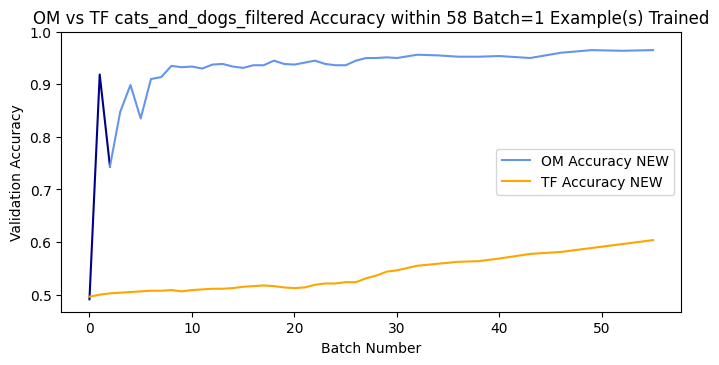

Labels   [[1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0
  0 1 0 0 0]]


In [54]:
# plot figure
print('first',graph_points[grange],'plots')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

plt.plot(graph_points[0:(all_presented+1)],OM_learn_Vacc[0:(all_presented+1)],color='darkblue')
plt.plot(graph_points[all_presented:grange],OM_learn_Vacc[all_presented:grange],color='cornflowerblue', label='OM Accuracy NEW')
plt.plot(graph_points[0:grange],tf_learn_Vacc[0:grange],color='orange', label='TF Accuracy NEW')

plt.legend(loc='right')
plt.ylabel('Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
#plt.ylim([0.35,1.0])
plt.title("OM vs TF {} Accuracy within {} Batch={} Example(s) Trained".format(dataset_name,graph_points[grange],BATCH_SIZE))

plt.xlabel('Batch Number')
plt.show()
print('Labels  ',np.array(labels_presented)[0:grange].T)